**CellBi-ID workflow**

Before running this part make shure you have run:  run.py

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import networkx as nx
import scipy
import scanpy as sc
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score
import sklearn
import os 
from itertools import count
import igraph as ig
import leidenalg as la
from scipy.stats import bootstrap

from newFunc import *

In [3]:
namefile ="BT346"+"-"+"BT400"
Algo = "Luvain"
resolution = [0.1,0.2,0.3,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,3.0,4.0]
Bootstrap = getResol1(namefile,resolution)
best_Resol , plotinfo = getResol1(namefile,resolution)

Text(0.5, 0, ' Resolution ')

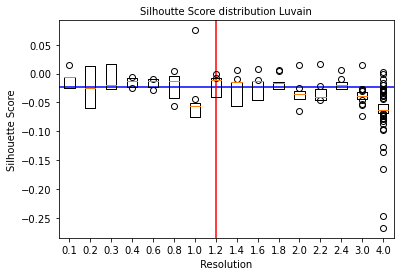

In [7]:
#Boxplot
stat = []
for i in range(len(plotinfo)):
    vT = plotinfo[i]
    diztemp = {
    "label": vT[0],  
    
    "med": vT[2],
    "q1": vT[3],
    "q3": vT[6],
    
    "whislo": vT[3],  
    "whishi": vT[6],  
    "fliers": vT[7]  
    }
    stat.append(diztemp)
    
    
fgd = pd.DataFrame(plotinfo)

import matplotlib.pyplot as plt
fs = 10  # fontsize

fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.axhline(y=max(fgd[3]), color='b', linestyle='-')
axes.axvline(x =8.0, color='r', linestyle='-')

axes.bxp(stat,showfliers=True)
axes.set_title('Silhoutte Score distribution Luvain', fontsize=fs)
axes.set_ylabel("Silhouette Score")
axes.set_xlabel(" Resolution ")


In [3]:
#Load Data 
adataB = sc.read_h5ad('DataPerPy/SeuratObj/BT346.h5ad')
adataS = sc.read_h5ad('DataPerPy/SeuratObj/BT400.h5ad')
adataB = adataB[adataB.obs["celltypesign"] != "unasigned"]
adataS = adataS[adataS.obs["celltypesign"] != "unasigned"]

res = best_Resol[0]


In [9]:
D = pd.read_csv("ReM/"+Algo+"/residualmatrix-"+namefile+"-"+str(res)+".csv",index_col=[0]).to_numpy()
df =pd.read_csv("ReM/"+Algo+"/cluster-"+namefile+"-"+str(res)+".csv")
labels_tot =list(pd.read_csv("ReM/"+Algo+"/cluster-"+namefile+"-"+str(res)+".csv")["clusterOverall"])
N_ofC_tot = len(df["clusterOverall"].value_counts())
N_ofC = len(df["clusterOverall"].value_counts()[df["clusterOverall"].value_counts() >1])
siloutte = sklearn.metrics.silhouette_samples(D, labels_tot)


In [10]:
countV = df[["node","clusterOverall"]].set_index("node").value_counts() 
countV = countV[countV ==1] #Se posso stabilire che min numero cellule per cluster = 6 allora plot più belli e interpretabili
listrename = [i[0] for i in list(countV.index)]
adataS.obs["cluster-"+Algo] = pd.Categorical(list(df.iloc[:2937][["node","clusterOverall"]].set_index("node").replace(listrename,"unasigned")["clusterOverall"]))
adataB.obs["cluster-"+Algo] = pd.Categorical(list(df.iloc[2937:][["node","clusterOverall"]].set_index("node").replace(listrename,"unasigned")["clusterOverall"]))


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


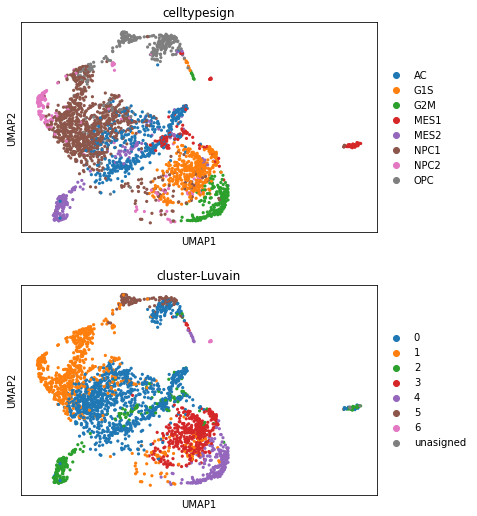

In [12]:
sc.pl.umap(adataS, color=["celltypesign","cluster-"+Algo],ncols=1)#,vmin= 0., vmax=20.#,"silux"


... storing 'celltypenature' as categorical
... storing 'celltypetot' as categorical
... storing 'celltypesign' as categorical


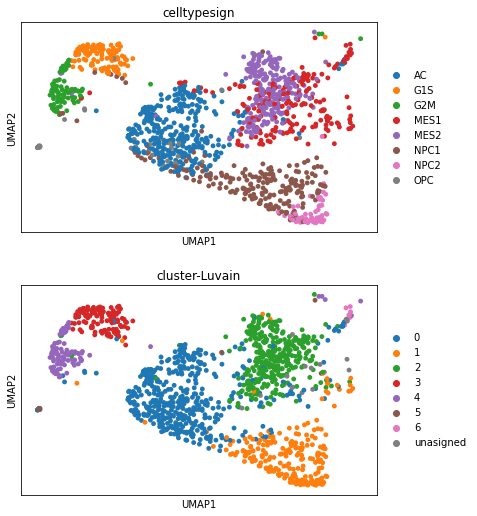

In [13]:
sc.pl.umap(adataB, color=["celltypesign","cluster-"+Algo],ncols=1)#,"silux"


In [14]:
adataB.obs["bipartite"] = np.zeros(len(adataB.obs))
adataS.obs["bipartite"] = np.ones(len(adataS.obs))
dfClusterTot = pd.concat([adataB.obs[["bipartite","celltypesign","cluster-"+Algo]],adataS.obs[["bipartite","celltypesign","cluster-"+Algo]]])

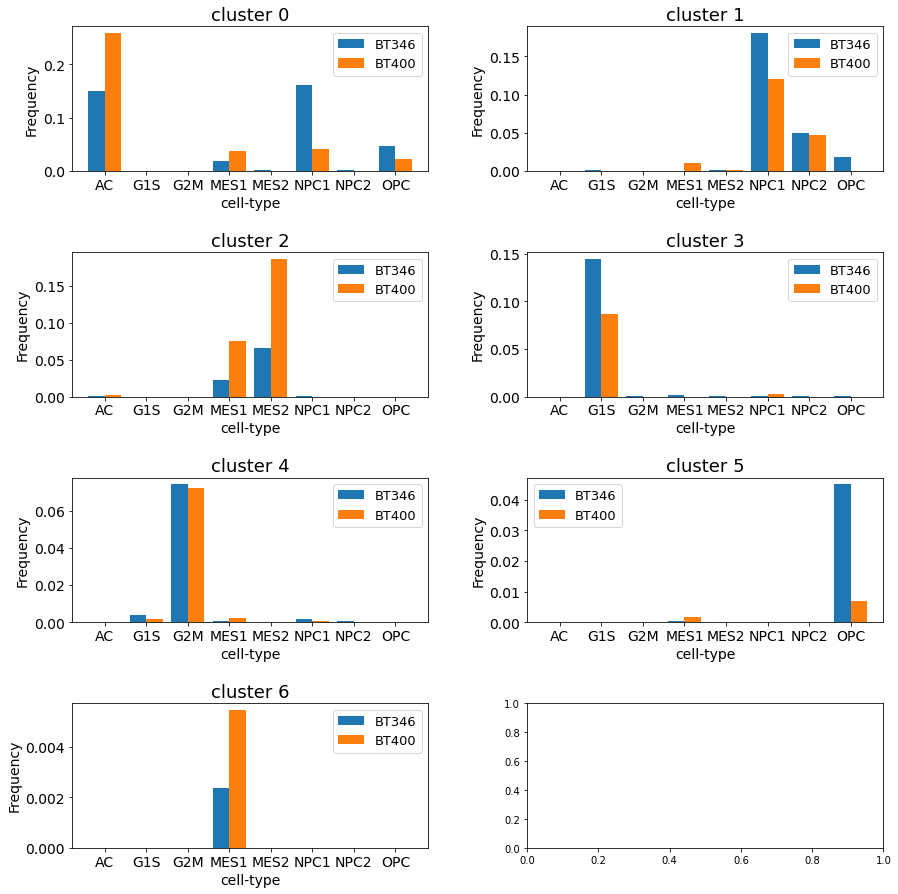

In [19]:
import numpy as np 
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(nrows=4, ncols=2,figsize=(12,12))#, figsize=(40, 60)
fig.tight_layout(h_pad = 6.00,w_pad = 6.8)
ii,jj=0,0
PLOTS_PER_ROW = 2


for i in np.unique(list(dfClusterTot["cluster-Luvain"])):
    if i != "unasigned":
        dfTemp = dfClusterTot.loc[dfClusterTot["cluster-"+Algo]==int(i)]
        dfStemp = dfTemp.loc[dfTemp["bipartite"]==1.0]
        dfBtemp = dfTemp.loc[dfTemp["bipartite"]==0.0]
        dfStemp = dfStemp.groupby("celltypesign").count()["cluster-"+Algo].to_frame().rename(columns ={"cluster-"+Algo : "clusterS"})
        dfBtemp = dfBtemp.groupby("celltypesign").count()["cluster-"+Algo].to_frame().rename(columns ={"cluster-"+Algo : "clusterB"})
        dfBtemp = dfBtemp.div(len(adataB.obs))
        dfStemp = dfStemp.div(len(adataS.obs))
        dfZ = pd.concat([dfStemp,dfBtemp],axis =1).fillna(0)
        YS = list(dfZ["clusterS"])
        YB = list(dfZ["clusterB"])
        X = list(dfZ.index)
        X_axis = np.arange(len(X))
        axs[ii][jj].bar(X_axis - 0.2, YS, 0.4, label = 'BT346')
        axs[ii][jj].bar(X_axis + 0.2, YB, 0.4, label = 'BT400')
        axs[ii][jj].set_xticks(X_axis)
        axs[ii][jj].set_xticklabels(X,fontsize = 14)
        axs[ii][jj].tick_params(axis='y', labelsize=14)
        axs[ii][jj].set_xlabel("cell-type",fontsize = 14)
        axs[ii][jj].set_ylabel("Frequency",fontsize = 14)
        axs[ii][jj].set_title("cluster " + i,fontsize = 18)
        axs[ii][jj].legend(prop={'size': 13})
        jj+=1
        if jj%PLOTS_PER_ROW==0:
            ii+=1
            jj=0
    

In [20]:
l1 = list(adataS.obs["celltypenature"])
l2 = list(adataB.obs["celltypenature"])
l3 = list(adataS.obs["cluster-"+Algo])
l4= list(adataB.obs["cluster-"+Algo])
l1 = l1+l2 
l2 = l3+l4
adjusted_mutual_info_score(l1, l2)

0.20010761779333763

In [22]:
l1 = list(adataS.obs["celltypesign"])
l2 = list(adataB.obs["celltypesign"])
l3 = list(adataS.obs["cluster-"+Algo])
l4= list(adataB.obs["cluster-"+Algo])
l1 = l1+l2 
l2 = l3+l4
adjusted_mutual_info_score(l1, l2)

0.6452584666626354